In [ ]:
import sys
sys.path.append('..')

import torch
import torch.nn.utils.prune as prune

from models.simple_vit import ViT

import matplotlib.pyplot as plt
import pandas as pd

# Pruning by Layer

In [89]:
model = ViT(
    in_channels = 2, 
    d_embed = 128,
    n_heads = 8,
    n_layers = 8, 
    img_shape = (256, 256), 
    patch_shape = (8, 8)
)
for module, name in model.get_parameters_to_prune():
    prune.identity(module, name)

iteration = 11
checkpoint_path = f"/glade/derecho/scratch/jshen/pruning-turbulence-vit/prune_unstructured_1/pruned_models/iteration_{iteration}.pt"

state_dict = torch.load(checkpoint_path, map_location='cpu')
model.load_state_dict(state_dict)

model.eval()

ViT(
  (patch_embed): PatchEmbed2D(
    (conv): Conv2d(2, 128, kernel_size=(8, 8), stride=(8, 8))
    (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  )
  (transformer_blocks): ModuleList(
    (0-7): 8 x TransformerBlock(
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (attn): FlashAttention()
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (mlp): MLP(
        (activation): GELU(approximate='none')
        (dropout): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
  (upsample): SubPixelConv2D(
    (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False, padding_mode=circular)
    (pixel_shuffle): PixelShuffle(upscale_factor=8)
  )
)

In [90]:
def pruning_by_layer(model):
    modules = {
        module_name: [] for module_name in 
        ['Q', 'K', 'V', 'out_proj', 'W_up', 'W_down', 'bias_up', 'bias_down']
    }

    for block_index, block in enumerate(model.transformer_blocks):

        attn = block.attn
        qkv_mask = attn.QKV_mask.reshape(attn.d_embed, attn.n_heads, 3, attn.d_attn)
        q_mask, k_mask, v_mask = qkv_mask.unbind(dim=2)

        modules['Q'].append((1 - q_mask.sum() / q_mask.numel()).item())
        modules['K'].append((1 - k_mask.sum() / k_mask.numel()).item())
        modules['V'].append((1 - v_mask.sum() / v_mask.numel()).item())
        modules['out_proj'].append((1 - attn.out_proj_mask.sum() / attn.out_proj_mask.numel()).item())
        modules['W_up'].append((1 - block.mlp.W_up_mask.sum() / block.mlp.W_up_mask.numel()).item())
        modules['W_down'].append((1 - block.mlp.W_down_mask.sum() / block.mlp.W_down_mask.numel()).item())
        modules['bias_up'].append((1 - block.mlp.bias_up_mask.sum() / block.mlp.bias_up_mask.numel()).item())
        modules['bias_down'].append((1 - block.mlp.bias_down_mask.sum() / block.mlp.bias_down_mask.numel()).item())

    return pd.DataFrame(modules)

all_data = pruning_by_layer(model)

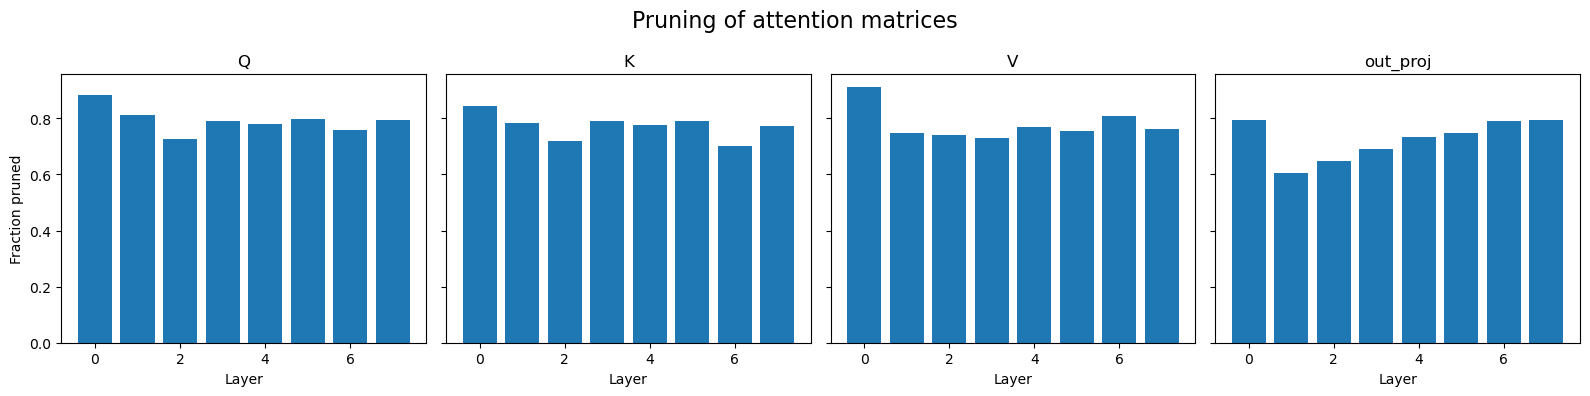

In [91]:
attn_data = all_data[['Q', 'K', 'V', 'out_proj']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of attention matrices', fontsize=16)
fig.tight_layout()

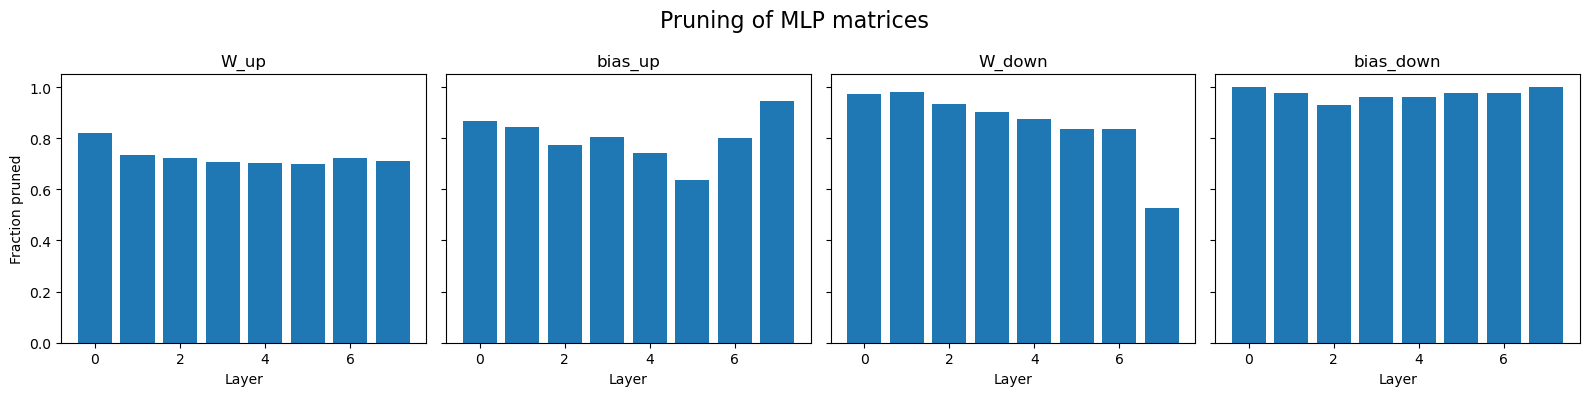

In [92]:
attn_data = all_data[['W_up', 'bias_up', 'W_down', 'bias_down']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of MLP matrices', fontsize=16)
fig.tight_layout()

# Pruning by Iteration

In [93]:
model = ViT(
    in_channels = 2, 
    d_embed = 128,
    n_heads = 8,
    n_layers = 8, 
    img_shape = (256, 256), 
    patch_shape = (8, 8)
)
for module, name in model.get_parameters_to_prune():
    prune.identity(module, name)

In [94]:
by_iteration = []

for iteration in range(12):
    checkpoint_path = f"/glade/derecho/scratch/jshen/pruning-turbulence-vit/prune_unstructured_1/pruned_models/iteration_{iteration}.pt"

    state_dict = torch.load(checkpoint_path, map_location='cpu')
    model.load_state_dict(state_dict)
    model.eval()

    by_layer = pruning_by_layer(model)
    by_iteration.append(by_layer.mean(axis=1))

by_iteration = pd.DataFrame(by_iteration)
by_iteration.columns = by_layer.columns

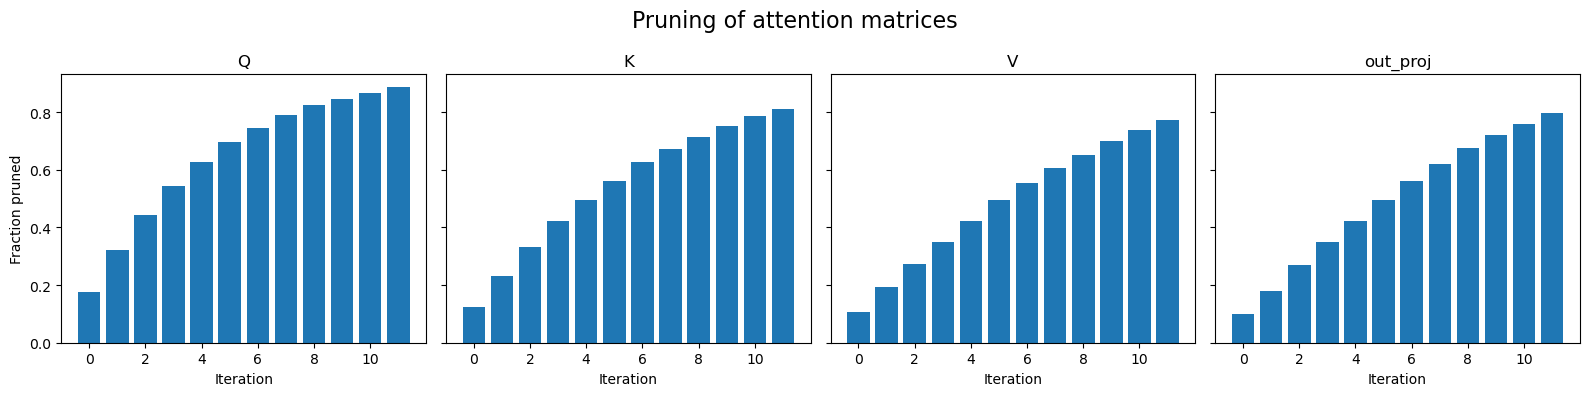

In [95]:
attn_data = by_iteration[['Q', 'K', 'V', 'out_proj']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Iteration')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of attention matrices', fontsize=16)
fig.tight_layout()

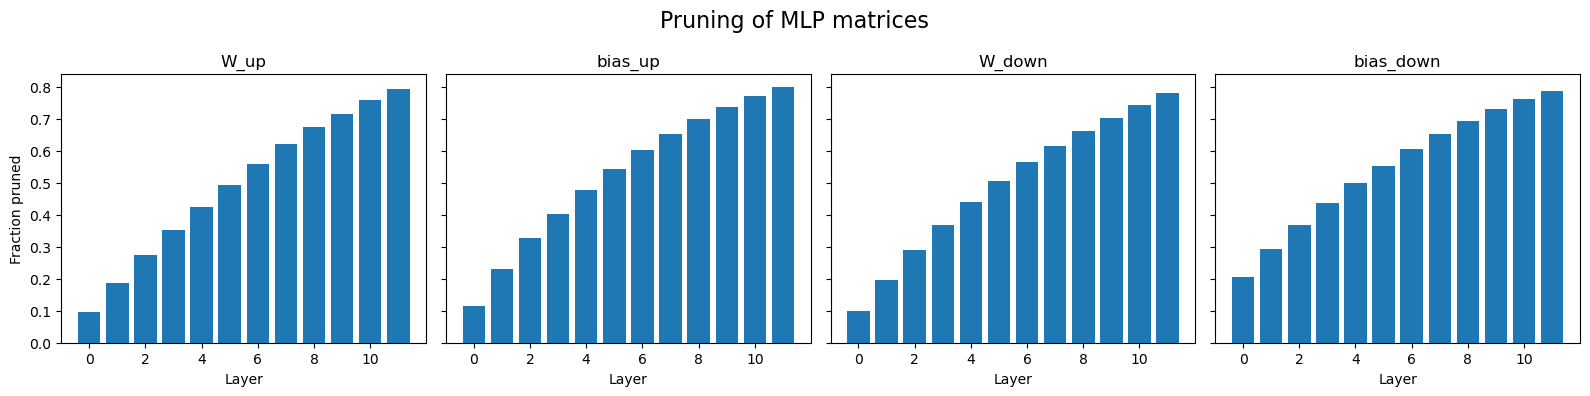

In [96]:
attn_data = by_iteration[['W_up', 'bias_up', 'W_down', 'bias_down']]

fig, axs = plt.subplots(1, attn_data.shape[1], figsize=(attn_data.shape[1] * 4, 4), sharey=True)

for i, ax in enumerate(axs):
    ax.bar(range(attn_data.shape[0]), attn_data.iloc[:, i])
    ax.set_title(attn_data.columns[i])
    ax.set_xlabel('Layer')

axs[0].set_ylabel('Fraction pruned')
fig.suptitle('Pruning of MLP matrices', fontsize=16)
fig.tight_layout()